# Hybrid Approach

하이브리드 접근법은 크게 3가지 대분류와 7가지 종류로 확인할 수 있습니다.

1. Monolithic hybrid designs
> 다양한 feature를 활용하는 단일 모델
  - Feature combination
  - Feature Augmentation
2. Parallelized hybrid design
> 여러 추천 시스템 간의 병렬적인 사용
  - Weighted
  - Switching
  - Mixed
3. Pipelined hybrid designs
> 후속 입력을 위해 일부 입력을 사전 처리하는 방식
  - Cascade
  - Meta‐level


In [1]:
# # install packages
# !pip install catboost -q
# !pip install scikit-surprise -q

In [1]:
# import packages
import pandas as pd
import numpy as np
import warnings

import re
from pandas.api.types import CategoricalDtype
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, LGBMRanker
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from surprise import Dataset, Reader, accuracy, SVD, KNNBasic, CoClustering
from surprise.dataset import DatasetAutoFolds

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

## Exploratory Data Analysis, 탐색적 데이터 분석

In [2]:
books = pd.read_csv('/opt/ml/data/books.csv')
users = pd.read_csv('/opt/ml/data/users.csv')
ratings = pd.read_csv('/opt/ml/data/train_ratings.csv')

In [3]:
books.shape, users.shape, ratings.shape

((149570, 10), (68092, 3), (306795, 3))

In [4]:
books['isbn'] = books['img_url'].apply(lambda x: x.split('P/')[1][:10])

In [5]:
print("<<< Dataframe users Example >>>")
print('users shape:\n', users.shape)
print('\ncol nunique:\n', users.nunique(),end='\n\n')
display(users.head(3))

<<< Dataframe users Example >>>
users shape:
 (68092, 3)

col nunique:
 user_id     68092
location    18368
age            91
dtype: int64



,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN


In [6]:
print("<<< Dataframe books Example >>>")
print('books shape:\n', books.shape)
print('\ncol nunique:\n', books.nunique(),end='\n\n')
display(books.head(3))

<<< Dataframe books Example >>>
books shape:
 (149570, 10)

col nunique:
 isbn                   149570
book_title             135436
book_author             62059
year_of_publication        95
publisher               11571
img_url                149570
language                   26
category                 4292
summary                 79872
img_path               149570
dtype: int64



,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg


In [7]:
print("<<< Dataframe ratings >>>")
print('ratings shape:\n', ratings.shape)
print('\ncol nunique:\n', ratings.nunique(),end='\n\n')
display(ratings.head(3))

<<< Dataframe ratings >>>
ratings shape:
 (306795, 3)

col nunique:
 user_id     59803
isbn       129777
rating         10
dtype: int64



,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8


### 데이터 가공하기

In [8]:
user2idx = {v:k for k,v in enumerate(ratings['user_id'].unique())}
book2idx = {v:k for k,v in enumerate(ratings['isbn'].unique())}

ratings['iid'] = ratings['isbn'].map(book2idx)
ratings['uid'] = ratings['user_id'].map(user2idx)

In [9]:
ratings.head(3)

,user_id,isbn,rating,iid,uid
0,8,0002005018,4,0,0
1,67544,0002005018,7,0,1
2,123629,0002005018,8,0,2


In [10]:
print('books 데이터 프레임의 결측치')
books.isnull().sum()

books 데이터 프레임의 결측치


isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [12]:
print('users 데이터 프레임의 결측치')
users.isnull().sum()

users 데이터 프레임의 결측치


user_id         0
location        0
age         27833
dtype: int64

In [12]:
print('ratings 데이터 프레임의 결측치')
ratings.isnull().sum()

ratings 데이터 프레임의 결측치


user_id    0
isbn       0
rating     0
iid        0
uid        0
dtype: int64

In [13]:
books.fillna(-1,inplace=True)
users.fillna(-1,inplace=True)
ratings.fillna(-1,inplace=True)

user-item에 대한 interaction matrix를 만들어 줍니다.
메모리 관리를 위해 pivot 대신 coo matrix로 만듭니다.

In [14]:
from pandas.api.types import CategoricalDtype
from scipy import sparse

size_uid = ratings["uid"].unique()
size_iid = ratings["iid"].unique()

ui_shape = (len(size_uid), len(size_iid))

user_cat = CategoricalDtype(categories=sorted(size_uid), ordered=True)
book_cat = CategoricalDtype(categories=sorted(size_iid), ordered=True)

user_index = ratings["uid"].astype(user_cat).cat.codes
book_index = ratings["iid"].astype(book_cat).cat.codes

interactions = sparse.coo_matrix((ratings["rating"], (user_index,book_index)), shape=ui_shape)

In [15]:
user_index = ratings["uid"].astype(user_cat).cat.codes
ratings["uid"].astype(user_cat).cat.categories, ratings["uid"].astype(user_cat).cat.codes 

(Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             59793, 59794, 59795, 59796, 59797, 59798, 59799, 59800, 59801,
             59802],
            dtype='int64', length=59803),
 0            0
 1            1
 2            2
 3            3
 4            4
           ... 
 306790    6313
 306791    1879
 306792    1879
 306793    1879
 306794    1879
 Length: 306795, dtype: int32)

In [16]:
user_cat = CategoricalDtype(categories=sorted(size_uid), ordered=True)
user_cat

CategoricalDtype(categories=[    0,     1,     2,     3,     4,     5,     6,     7,
                      8,     9,
                  ...
                  59793, 59794, 59795, 59796, 59797, 59798, 59799, 59800,
                  59801, 59802],
, ordered=True)

In [17]:
interactions

<59803x129777 sparse matrix of type '<class 'numpy.int64'>'
	with 306795 stored elements in COOrdinate format>

In [18]:
def check_sparsity(interactions:sparse.coo_matrix)->int:
  matrix_size = interactions.shape[0]*interactions.shape[1] # Number of possible interactions in the matrix
  num_purchases = len(interactions.nonzero()[0]) # Number of items interacted with
  sparsity = 100*(1 - (num_purchases/matrix_size))
  return round(sparsity,4)

In [19]:
print(f"matrix sparsity : {check_sparsity(interactions)}%")

matrix sparsity : 99.996%


Train, Test를 분할합니다.

- 행렬에서 0이 아닌 즉, 평가 기록이 있는 데이터
를 랜덤하게 Train, Test 로 나눠 줍니다.
- data를 shuffle한 후, 유저를 기준으로 나눕니다.

In [20]:
def shuffle_data(interactions:sparse.coo_matrix, random_state:int=42)->tuple:
    random_state = np.random.RandomState(seed=random_state)

    interactions = interactions.tocoo()

    uids, iids, data = (interactions.row, interactions.col, interactions.data)

    shuffle_indices = np.arange(len(uids))
    random_state.shuffle(shuffle_indices)

    uids = uids[shuffle_indices]
    iids = iids[shuffle_indices]
    data = data[shuffle_indices]

    return uids, iids, data

In [21]:
def cutoff_by_user(uids:list, test_percentage:float=0.2):
    cutoff = int((1.0 - test_percentage) * len(uids))
    train_idx = slice(None, cutoff)
    test_idx = slice(cutoff, None)
    return train_idx, test_idx

In [22]:
# 위치에 맞게 평가 기록을 추가하는 코드를 작성합니다.
def random_train_test_split(interactions, test_percentage=0.2, valid=None, random_state=42):
    uids, iids, data = shuffle_data(interactions, random_state)
    train_idx, test_idx = cutoff_by_user(uids, test_percentage)
    shape = interactions.shape

    train = sparse.coo_matrix(
        (data[train_idx], (uids[train_idx], iids[train_idx])),
        shape=shape,
        dtype=interactions.dtype,
    )
    test = sparse.coo_matrix(
        (data[test_idx], (uids[test_idx], iids[test_idx])),
        shape=shape,
        dtype=interactions.dtype,
    )
    return train, test

In [23]:
train, test = random_train_test_split(interactions,test_percentage=0.2,random_state=42)

In [24]:
train = train.tocsr()
test = test.tocsr()

In [25]:
train, test

(<59803x129777 sparse matrix of type '<class 'numpy.int64'>'
 	with 245436 stored elements in Compressed Sparse Row format>,
 <59803x129777 sparse matrix of type '<class 'numpy.int64'>'
 	with 61359 stored elements in Compressed Sparse Row format>)

### Train / Test Split (DataFrame)

GBDT 모델도 사용하기 위해 데이터프레임도 만들겠습니다.
random_train_test_split에서 사용하였던 데이터와 동일하게 사용합니다.

In [26]:
uids, iids, data = shuffle_data(interactions)
train_idx, test_idx = cutoff_by_user(uids)

train_df = pd.DataFrame({'uid':uids[train_idx], 'iid':iids[train_idx], 'ratings':data[train_idx]})
test_df = pd.DataFrame({'uid':uids[test_idx], 'iid':iids[test_idx], 'ratings':data[test_idx]})

In [27]:
train_df.shape, test_df.shape

((245436, 3), (61359, 3))

In [28]:
train_df.head()

,uid,iid,ratings
0,15485,1638,7
1,10191,13639,6
2,16627,125648,8
3,3459,103855,7
4,2266,795,9


### Feature Engineering

contents based recommender 모델을 위한 여러 feature를 생성합니다.

#### User

In [29]:
users_location = pd.concat(
    [users.drop('location', axis=1), 
     (users['location'].str.split(',', expand=True)
     .assign(location_country = lambda x : np.where(x[2]=='', x[3], x[2]),
            location_state = lambda x : x[1],
            location_city = lambda x : x[0],
            ) 
      )[['location_country', 'location_state', 'location_city']]
     ], axis=1)

city_tab = pd.DataFrame([['iowa city','iowa','usa'],
['somerset', 'somerset','england'],
['milford','massachusetts','usa'],
['rockvale','tennessee','usa'],
['bronx','newyork','usa'],
['tustin','california','usa'],
['choctaw','choctaw','usa'],
['richmond hill','richmond hill','canada'],
['kuala lumpur','kuala lumpur','malaysia']])
city_tab.columns = ['city','state','country']

for _,row in city_tab.iterrows():
    location_idx = users_location['location_city'] == row.city
    users_location.loc[location_idx,'location_city'] = row.city
    users_location.loc[location_idx,'location_state'] = row.state
    users_location.loc[location_idx,'location_country'] = row.country

users_location.fillna('unknown',inplace=True)
users_location['location_country'] = users_location['location_country'].str.replace('n/a','unknown')
users_location['location_city'] = users_location['location_city'].str.replace('n/a','unknown')
users_location['location_state'] = users_location['location_state'].str.replace('n/a','unknown')

In [30]:
users_df = users_location.copy()
users_df['uid'] = users_df['user_id'].map(user2idx)

In [31]:
users_df.head()

,user_id,age,location_country,location_state,location_city,uid
0,8,-1.0,canada,ontario,timmins,0.0
1,11400,49.0,canada,ontario,ottawa,2334.0
2,11676,-1.0,unknown,unknown,unknown,13.0
3,67544,30.0,canada,ontario,toronto,1.0
4,85526,36.0,canada,british columbia,victoria,4789.0


In [32]:
users_df.isnull().sum()

user_id                0
age                    0
location_country       0
location_state         0
location_city          0
uid                 8289
dtype: int64

In [33]:
u_label = ['location_country', 'location_state', 'location_city']
u_encoder = dict()
for l in u_label:
    u_encoder[l] = LabelEncoder()
    u_encoder[l].fit(users_df[l])
    users_df[l] = u_encoder[l].transform(users_df[l])

In [34]:
users_df['age'] = users_df['age'].map(lambda x:x//10 if type(x)!= str else -1)

In [35]:
users_df.head()

,user_id,age,location_country,location_state,location_city,uid
0,8,-1.0,55,1050,10871,0.0
1,11400,4.0,55,1050,8071,2334.0
2,11676,-1.0,315,1428,11127,13.0
3,67544,3.0,55,1050,10928,1.0
4,85526,3.0,55,225,11310,4789.0


#### Item

In [36]:
books_df = books.copy()
books_df['iid'] = books_df['isbn'].map(book2idx)

In [37]:
books_df['category'] = books_df['category'].apply(lambda x: re.sub('[\W_]+',' ',str(x)).strip())

In [38]:
books_df['category'] = books_df['category'].astype(str)
books_df['language'] = books_df['language'].astype(str)

In [39]:
i_label = ['category', 'language']
i_encoder = dict()
for l in i_label:
    i_encoder[l] = LabelEncoder()
    i_encoder[l].fit(books_df[l])
    books_df[l] = i_encoder[l].transform(books_df[l])

In [40]:
train_context = train_df.merge(users_df,on='uid',how='left').merge(books_df, on='iid',how='left')
test_context = test_df.merge(users_df,on='uid',how='left').merge(books_df, on='iid',how='left')

In [41]:
train_context.isna().sum()

uid                    0
iid                    0
ratings                0
user_id                0
age                    0
location_country       0
location_state         0
location_city          0
isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_url                0
language               0
category               0
summary                0
img_path               0
dtype: int64

In [42]:
X_train = train_context.drop(['user_id', 'isbn', 'iid','uid', 'ratings'], axis=1)
y_train = train_context['ratings']
rating_train = train_context[['uid','iid','ratings']] 

X_test = test_context.drop(['user_id', 'isbn', 'iid','uid', 'ratings'], axis=1)
y_test = test_context['ratings']
rating_test = test_context[['uid','iid','ratings']]

In [43]:
X_train.head()

,age,location_country,location_state,location_city,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,-1.0,320,1045,2340,A Lesson Before Dying (Vintage Contemporaries ...,Ernest J. Gaines,1997.0,Vintage Books USA,http://images.amazon.com/images/P/0375702709.0...,5,153,A Lesson Before Dying tells the story of these...,images/0375702709.01.THUMBZZZ.jpg
1,1.0,320,823,388,Confessional,Jack Higgins,1986.0,Signet Book,http://images.amazon.com/images/P/0451143752.0...,0,2,-1,images/0451143752.01.THUMBZZZ.jpg
2,5.0,320,1045,2340,Eyes of a Child: A Novel,Richard North Patterson,1994.0,Random House Trade,http://images.amazon.com/images/P/0679439528.0...,0,2,-1,images/0679439528.01.THUMBZZZ.jpg
3,3.0,320,1045,4400,Day of Wrath,Jonathan Valin,1994.0,Dell Publishing Company,http://images.amazon.com/images/P/0440210410.0...,0,2,-1,images/0440210410.01.THUMBZZZ.jpg
4,3.0,320,635,2066,Girl in Hyacinth Blue,Susan Vreeland,2000.0,Penguin Books,http://images.amazon.com/images/P/014029628X.0...,0,2,-1,images/014029628X.01.THUMBZZZ.jpg


In [44]:
y_train.head()

0    7
1    6
2    8
3    7
4    9
Name: ratings, dtype: int64

In [45]:
rating_test

,uid,iid,ratings
0,41848,33783,9
1,6538,2644,8
2,11221,81890,10
3,16021,6142,9
4,4632,89180,3
...,...,...,...
61354,2752,14936,6
61355,8108,86566,7
61356,10534,18168,5
61357,40246,22419,8


In [46]:
drop_lst = ['book_title','book_author','publisher','img_url','img_path','summary']

X_train.drop(drop_lst,axis=1,inplace=True)
X_test.drop(drop_lst,axis=1,inplace=True)

마찬가지로 RAM 관리를 위해 사용하지 않는 데이터 프레임을 삭제할 수도 있습니다. magic command 를 사용하여 현행 정의해놓은 변수 목록을 확인한 후, 삭제 가능합니다. (*길이상 주석처리하여 놓았습니다.)

In [47]:
%whos

Variable                  Type                Data/Info
-------------------------------------------------------
CatBoostClassifier        type                <class 'catboost.core.CatBoostClassifier'>
CatBoostRegressor         type                <class 'catboost.core.CatBoostRegressor'>
CategoricalDtype          type                <class 'pandas.core.dtype<...>dtypes.CategoricalDtype'>
CoClustering              type                <class 'surprise.predicti<...>clustering.CoClustering'>
Dataset                   type                <class 'surprise.dataset.Dataset'>
DatasetAutoFolds          type                <class 'surprise.dataset.DatasetAutoFolds'>
KNNBasic                  type                <class 'surprise.predicti<...>lgorithms.knns.KNNBasic'>
LGBMClassifier            type                <class 'lightgbm.sklearn.LGBMClassifier'>
LGBMRanker                type                <class 'lightgbm.sklearn.LGBMRanker'>
LGBMRegressor             type                <class 'lightgbm

In [48]:
del ratings, users, books, books_df, users_df, users_location, city_tab

In [49]:
def modify_range(rating):
  if rating < 0:
    return 0
  elif rating > 10:
    return 10
  else:
    return rating

In [50]:
def rmse(real, predict):
  pred = list(map(modify_range, predict))  
  pred = np.array(pred)
  return np.sqrt(np.mean((real-pred) ** 2))

In [51]:
def matrix_rmse(real_mat, predict_mat, test_ind=test_idx):
  cost = 0

  for i, ind in enumerate(test_ind):
    pred = predict_mat[ind]
    real = real_mat[ind]
    cost += pow(real - modify_range(pred), 2)
  return np.sqrt(cost/ len(test_ind)) 

## 단일 모델 확보

### SVD

In [52]:
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(train_df[['uid', 'iid', 'ratings']], reader)
test_data = Dataset.load_from_df(test_df[['uid', 'iid', 'ratings']], reader)

In [54]:
fold = DatasetAutoFolds(df = train_df[['uid', 'iid', 'ratings']], reader = reader)
trainset = fold.build_full_trainset()

In [55]:
trainset

In [67]:
params = {'n_factors':10,
          'n_epochs':20,
          'lr_all':0.005,
          'reg_all':0.02}

svd = SVD(**params,random_state=42)


In [68]:
svd.fit(trainset)

In [69]:
uir_tuple = list(zip(test_df['uid'], test_df['iid'],test_df['ratings']))

In [70]:
svd_test = svd.test(uir_tuple)

In [71]:
svd_pred = list(map(lambda x:round(x.est), svd_test))
pd.Series(svd_pred).value_counts()

7     28590
8     15775
6      8060
9      4819
5      2119
4       775
3       728
10      438
2        46
1         9
dtype: int64

모델의 성능을 파악하기 위한 score dictionary를 생성하고, SVD 모델의 RMSE를 기록합니다.
파라미터 또한 기록하여 줍니다.

In [72]:
param = {}
param['svd'] = params

In [73]:
score = {}
score['svd'] = rmse(y_test, svd_pred)

In [74]:
pred = {}
pred['svd'] = svd_pred

In [75]:
rmse_v = score['svd']
print(f"RMSE of svd : {round(rmse_v,4)}")

RMSE of svd : 2.2048


### Co-clustering
사용자와 아이템에 각각 $C_
u$,$C_i$,$C_ui$ 클러스터가 부여되고, 이에 대한 평균 평점에서부터 평점을 계산합니다.


$$
\hat{r}_{ui} = \overline{C_{ui}} + (\mu_u - \overline{C_u}) + (\mu_i- \overline{C_i})
$$

In [70]:
params = {'n_cltr_u':10, 'n_cltr_i':10, 'n_epochs':20}
param['coclu'] = params

In [71]:
coclu = CoClustering(**params, random_state=42, verbose=True)
coclu.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [72]:
coclu_test = coclu.test(uir_tuple)

In [73]:
coclu_pred = list(map(lambda x:round(x.est), coclu_test))
pd.Series(coclu_pred).value_counts()

7     32177
8      8233
9      5971
6      4491
10     4174
5      2650
4      1460
3       996
1       607
2       600
dtype: int64

In [74]:
pred['coclu'] = coclu_pred

In [75]:
score['coclu'] = rmse(y_test, coclu_pred)

In [76]:
rmse_v = score['coclu']
print(f"RMSE of coclustering : {round(rmse_v,4)}")

RMSE of coclustering : 2.5071


### LGBM

In [77]:
params = {'objective':'rmse',
  'boosting_type':'gbdt',
  'lambda': 0.1,
 'learning_rate': 0.03,
 'max_depth': 34,
 'num_leaves': 34,
 'n_epochs': 18}
param['lgbm'] = params

In [78]:
lgbm_cl = LGBMClassifier(**params ,random_state=42)
lgbm_cl.fit(X_train.select_dtypes(exclude='object'), y_train)

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


LGBMClassifier(lambda=0.1, learning_rate=0.03, max_depth=34, n_epochs=18,
               num_leaves=34, objective='rmse', random_state=42)

In [79]:
lgbm_pred_cl = lgbm_cl.predict(X_test.select_dtypes(exclude='object'))

In [80]:
pd.Series(lgbm_pred_cl).value_counts()

8     56261
10     2752
9      1039
2       463
7       437
4       284
3        78
1        45
dtype: int64

In [81]:
score['lgbm_cl'] = rmse(y_test,lgbm_pred_cl)
score['lgbm_cl']

2.586211332472691

In [82]:
pred['lgbm_cl'] = lgbm_pred_cl

In [83]:
rmse_v = score['lgbm_cl']
print(f"RMSE of lgbm_classifier : {round(rmse_v,4)}")

RMSE of lgbm_classifier : 2.5862


### LGBM Regressor

In [84]:
lgbm_r = LGBMRegressor(**params ,random_state=42)
lgbm_r.fit(X_train.select_dtypes(exclude='object'), y_train)
lgbm_pred_r = lgbm_r.predict(X_test.select_dtypes(exclude='object'))

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [85]:
score['lgbm_r'] = rmse(y_test,lgbm_pred_r)

In [86]:
pred['lgbm_r'] = lgbm_pred_r

<AxesSubplot: ylabel='Density'>

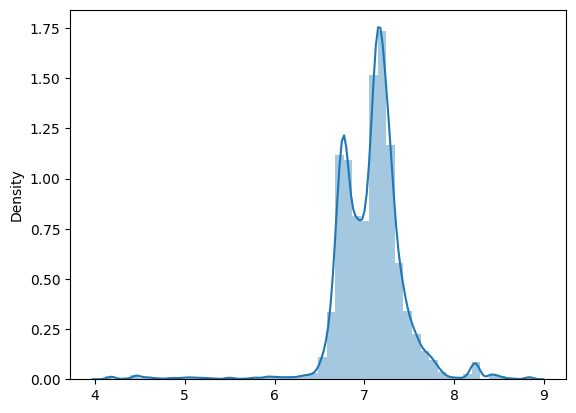

In [87]:
sns.distplot(pd.Series(lgbm_pred_r))

In [88]:
pd.Series(lgbm_pred_r).map(round).value_counts()

7    55455
8     4358
6      732
5      389
4      230
9      195
dtype: int64

In [89]:
rmse_v = score['lgbm_r']
print(f"RMSE of lgbm_Regressor : {round(rmse_v,4)}")

RMSE of lgbm_Regressor : 2.3655


### Catboost

In [90]:
params = {}
params['iterations'] = 100
params['learning_rate']=0.1
params['depth']=8

In [91]:
param['catboost'] = params

In [92]:
catboost_cl = CatBoostClassifier(**params, verbose=True, random_state=42)
catboost_cl.fit(X_train.select_dtypes(exclude='object'), y_train, early_stopping_rounds=100)
catboost_pred_cl = catboost_cl.predict(X_test.select_dtypes(exclude='object'))

0:	learn: 2.2560332	total: 289ms	remaining: 28.7s
1:	learn: 2.2188480	total: 454ms	remaining: 22.3s
2:	learn: 2.1900016	total: 607ms	remaining: 19.6s
3:	learn: 2.1669524	total: 766ms	remaining: 18.4s
4:	learn: 2.1478455	total: 966ms	remaining: 18.3s
5:	learn: 2.1321268	total: 1.13s	remaining: 17.7s
6:	learn: 2.1188289	total: 1.29s	remaining: 17.1s
7:	learn: 2.1074847	total: 1.46s	remaining: 16.8s
8:	learn: 2.0990061	total: 1.64s	remaining: 16.6s
9:	learn: 2.0896168	total: 1.79s	remaining: 16.1s
10:	learn: 2.0824848	total: 1.95s	remaining: 15.8s
11:	learn: 2.0764300	total: 2.13s	remaining: 15.6s
12:	learn: 2.0722995	total: 2.27s	remaining: 15.2s
13:	learn: 2.0687110	total: 2.4s	remaining: 14.7s
14:	learn: 2.0645701	total: 2.51s	remaining: 14.2s
15:	learn: 2.0611052	total: 2.63s	remaining: 13.8s
16:	learn: 2.0589962	total: 2.73s	remaining: 13.3s
17:	learn: 2.0563385	total: 2.84s	remaining: 12.9s
18:	learn: 2.0540074	total: 2.95s	remaining: 12.6s
19:	learn: 2.0523455	total: 3.06s	remainin

In [94]:
score['catboost_cl'] = rmse(y_test,catboost_pred_cl.squeeze(1))

In [95]:
pred['catboost_cl'] = catboost_pred_cl.squeeze(1)

In [96]:
rmse_v = score['catboost_cl']
print(f"RMSE of Catboost Classifier : {round(rmse_v,4)}")

RMSE of Catboost Classifier : 2.6095


### Catboost Regressor

In [97]:
catboost_r = CatBoostRegressor(**params, verbose=True, random_state=42)
catboost_r.fit(X_train.select_dtypes(exclude='object'), y_train, early_stopping_rounds=100)
catboost_pred_r = catboost_r.predict(X_test.select_dtypes(exclude='object'))

0:	learn: 2.4272136	total: 13.7ms	remaining: 1.36s
1:	learn: 2.4231070	total: 25.3ms	remaining: 1.24s
2:	learn: 2.4186433	total: 36.5ms	remaining: 1.18s
3:	learn: 2.4151338	total: 48ms	remaining: 1.15s
4:	learn: 2.4118752	total: 59.2ms	remaining: 1.12s
5:	learn: 2.4095519	total: 70ms	remaining: 1.1s
6:	learn: 2.4074097	total: 81.4ms	remaining: 1.08s
7:	learn: 2.4055620	total: 91.9ms	remaining: 1.06s
8:	learn: 2.4030234	total: 103ms	remaining: 1.04s
9:	learn: 2.4011160	total: 114ms	remaining: 1.02s
10:	learn: 2.3993301	total: 124ms	remaining: 1.01s
11:	learn: 2.3978596	total: 135ms	remaining: 987ms
12:	learn: 2.3971397	total: 145ms	remaining: 972ms
13:	learn: 2.3957467	total: 156ms	remaining: 960ms
14:	learn: 2.3950187	total: 166ms	remaining: 943ms
15:	learn: 2.3935887	total: 177ms	remaining: 931ms
16:	learn: 2.3925755	total: 188ms	remaining: 920ms
17:	learn: 2.3915903	total: 199ms	remaining: 906ms
18:	learn: 2.3898853	total: 210ms	remaining: 894ms
19:	learn: 2.3888299	total: 221ms	rema

In [98]:
score['catboost_r'] = rmse(y_test,catboost_pred_r)

In [99]:
pred['catboost_r'] = catboost_pred_r

In [100]:
rmse_v = score['catboost_r']
print(f"RMSE of Catboost Regressor : {round(rmse_v,4)}")

RMSE of Catboost Regressor : 2.362


## 하이브리드 접근법을 이용한 성능 개선

In [101]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.586211332472691,
 'lgbm_r': 2.3655060685545086,
 'catboost_cl': 2.609467172876271,
 'catboost_r': 2.3619752329052064}

### Simple Weight : 직접 지정

먼저, 직접 지정하는 방법입니다.

In [102]:
# 기본 Weight
def simple_weighted(output_list: list, weight: list):
    pred = []
    for arr in output_list:
        pred.append(arr)

    pred_arr = np.append([pred[0]], [pred[1]], axis=0)
    for i in range(2, len(pred)):
        pred_arr = np.append(pred_arr, [pred[i]], axis=0)
    
    result = np.dot(pred_arr.T, np.array(weight))
    return result

In [103]:
weighted_pred = simple_weighted([svd_pred,lgbm_pred_r,catboost_pred_r], weight=[0.5, 0.2, 0.3])

In [104]:
rmse_v = rmse(y_test, weighted_pred)
print(f"RMSE of Simple Weighted : {round(rmse_v,4)}")

RMSE of Simple Weighted : 2.2427


### Optimal Weight : 가중치 탐색

아래 코드를 통해 최적의 weight를 찾을 수도 있습니다.

먼저 Weight를 줄 모델을 선정하여 봅니다.

In [105]:
def find_suitable_model(score:dict,threshold:float)->list:
    suitable_models = [k for k,v in score.items() if v<threshold]
    return suitable_models

In [106]:
threshold = 3.4
suitable_models = find_suitable_model(score,threshold)
print(f"RMSE {threshold} 이하 모델 활용 : {suitable_models}")

RMSE 3.4 이하 모델 활용 : ['svd', 'coclu', 'lgbm_cl', 'lgbm_r', 'catboost_cl', 'catboost_r']


In [107]:
output_list = [pred[m] for m in suitable_models]

이를 random_weight 를 통해 optimal_weighted를 찾아보겠습니다.

In [108]:
def optimal_weighted(output_list: list, n:int)->dict:
    record = {'rmse':10,'weight':[]}
    
    for _ in range(n):
        random_weight = np.random.dirichlet(np.ones(len(output_list)),size=1).squeeze()
        pred_weight_zip = zip(output_list,random_weight)
        pred_weight_list = [pred*np.array(weight) for pred, weight in pred_weight_zip]
        pred_result = np.sum(pred_weight_list, axis=0)
        rmse_v = rmse(y_test,pred_result)
        if rmse_v < record['rmse']:
            record['rmse'] = rmse_v
            record['weight'] = random_weight
    return record

In [109]:
opt_w = optimal_weighted(output_list=output_list,n=100)
opt_w

{'rmse': 2.2106677121571767,
 'weight': array([0.71697096, 0.0820996 , 0.01120183, 0.06596056, 0.00945603,
        0.11431102])}

In [110]:
opt_weighted_pred = simple_weighted(output_list,
                                    weight=opt_w['weight'])

In [111]:
pred['opt_weight'] = opt_weighted_pred

In [112]:
rmse_v = rmse(y_test, opt_weighted_pred)
score['opt_weight'] = rmse_v
print(f"RMSE of Optimal Weighted : {round(rmse_v,4)}")

RMSE of Optimal Weighted : 2.2107


### Feature Combine

Feature Combine 방법을 이용하여, 타 모델에서 생성된 pred 값을 Input으로 사용합니다.

item과 user의 feature를 사용하는 LGBM, Catboost에 추가하여 넘겨주도록 하겠습니다.

In [113]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.586211332472691,
 'lgbm_r': 2.3655060685545086,
 'catboost_cl': 2.609467172876271,
 'catboost_r': 2.3619752329052064,
 'opt_weight': 2.2106677121571767}

In [114]:
train_uir_tuple = list(zip(train_df['uid'], train_df['iid'], train_df['ratings']))

In [115]:
X_train_combine = X_train.copy()
X_test_combine = X_test.copy()

#### Rating Feature 추가

여기서는 user-item 사이 interaction 데이터를 이용한 SVD, Co-clustering 알고리즘에서 예측한 pred_rating 에 대한 정보를 넘겨주도록 하겠습니다.

In [116]:
X_train_combine['svd_rating'] = list(map(lambda x:round(x.est), svd.test(train_uir_tuple)))
X_test_combine['svd_rating'] = svd_pred

In [117]:
X_train_combine['coclu_rating'] = list(map(lambda x:round(x.est), coclu.test(train_uir_tuple)))
X_test_combine['coclu_rating'] = coclu_pred

In [118]:
combined_lgbm_cl = LGBMClassifier(**param['lgbm'] , random_state=42)
combined_lgbm_cl.fit(X_train_combine.select_dtypes(exclude='object'), y_train)
com_lgbm_pred = combined_lgbm_cl.predict(X_test_combine.select_dtypes(exclude='object'))

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


#### 성능 향상

svd 모델에서 파생된 rating pred를 추가한 경우, 같은 파라미터를 사용한 기존 모델보다 성능을 훨씬 향상됨을 확인할 수 있습니다.

<!-- only SVD: 3.416 -->

In [120]:
pred['combined_lgbm_cl'] = com_lgbm_pred

In [121]:
rmse_v = rmse(y_test, com_lgbm_pred)
score['combined_lgbm_cl'] = rmse_v
print(f"RMSE of Combined LGBM Classifier : {round(rmse_v,4)}")

RMSE of Combined LGBM Classifier : 2.3183


In [122]:
improved = rmse_v - score['lgbm_cl']
print(f'feature combine improved RMSE {round(improved,4)}')

feature combine improved RMSE -0.2679


catboost의 case도 확인해 봅시다.

In [123]:
combined_catboost_cl = CatBoostClassifier(**param['catboost'], verbose=True, random_state=42)
combined_catboost_cl.fit(X_train_combine.select_dtypes(exclude='object'), y_train, early_stopping_rounds=100)
com_catboost_pred = combined_catboost_cl.predict(X_test_combine.select_dtypes(exclude='object'))

0:	learn: 2.0581268	total: 156ms	remaining: 15.4s
1:	learn: 1.9059725	total: 301ms	remaining: 14.8s
2:	learn: 1.7932623	total: 447ms	remaining: 14.4s
3:	learn: 1.7079473	total: 591ms	remaining: 14.2s
4:	learn: 1.6389242	total: 728ms	remaining: 13.8s
5:	learn: 1.5804348	total: 860ms	remaining: 13.5s
6:	learn: 1.5317402	total: 993ms	remaining: 13.2s
7:	learn: 1.4908307	total: 1.12s	remaining: 12.9s
8:	learn: 1.4559544	total: 1.25s	remaining: 12.6s
9:	learn: 1.4259334	total: 1.38s	remaining: 12.4s
10:	learn: 1.3997811	total: 1.52s	remaining: 12.3s
11:	learn: 1.3775113	total: 1.66s	remaining: 12.2s
12:	learn: 1.3572771	total: 1.79s	remaining: 12s
13:	learn: 1.3397092	total: 1.94s	remaining: 11.9s
14:	learn: 1.3238830	total: 2.09s	remaining: 11.8s
15:	learn: 1.3091488	total: 2.23s	remaining: 11.7s
16:	learn: 1.2960525	total: 2.38s	remaining: 11.6s
17:	learn: 1.2844471	total: 2.53s	remaining: 11.5s
18:	learn: 1.2751351	total: 2.68s	remaining: 11.4s
19:	learn: 1.2655476	total: 2.82s	remaining

In [124]:
pred['combined_catboost_cl'] = com_catboost_pred.squeeze(1)

In [125]:
rmse_v = rmse(y_test,com_catboost_pred.squeeze(1))
score['combined_catboost_cl'] = rmse_v
print(f"RMSE of Combined Catboost Classifier : {round(rmse_v,4)}")

RMSE of Combined Catboost Classifier : 2.316


In [126]:
improved = rmse_v - score['catboost_cl']
print(f'Feature combine improved RMSE {round(improved,4)}')

Feature combine improved RMSE -0.2935


### Mixed

일반적인 Mixed 형식의 하이브리드 접근법은 Ranking 문제에서 주로 사용하는 방식입니다.
예를 들어, top k를 추천할 때 n개의 모델에서 나온 item을 각각 섞어 k개를 선정하는 것을 들 수 있습니다.

prediction
을 목적으로 진행하는 이번 과제에서는 일반적인 mixed 형식은 어렵습니다.
이에 따라, 이번 미션에서는 케이스 별 모델에서 도출한 pred rating을 섞어 최종 결과로 사용하는 방식의 개량된 mixed approach에 대해 알아보겠습니다.

#### Case 분화

예시를 위해 pulication이 2000년 미만인 경우(20세기)와 이후인 경우(21세기)를 분화하여, 각각 다른 모델을 섞어보도록 하겠습니다.

In [127]:
X_train_combine_21cent = X_train_combine[~(X_train_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
X_train_combine_20cent = X_train_combine[X_train_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

In [128]:
y_train_21cent = y_train[~(X_train_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
y_train_20cent = y_train[X_train_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

In [129]:
X_test_combine_21cent = X_test_combine[~(X_test_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
X_test_combine_20cent = X_test_combine[X_test_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

In [130]:
y_test_21cent = y_test[~(X_test_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
y_test_20cent = y_test[X_test_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

In [131]:
# 20세기
lgbm_20cent = LGBMClassifier(**param['lgbm'] , random_state=42)
lgbm_20cent.fit(X_train_combine_20cent.select_dtypes(exclude='object'), y_train_20cent)
lgbm_20cent_pred = lgbm_20cent.predict(X_test_combine_20cent.select_dtypes(exclude='object'))

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [132]:
# 21세기
catboost_21cent = CatBoostClassifier(**param['catboost'] , random_state=42)
catboost_21cent.fit(X_train_combine_21cent.select_dtypes(exclude='object'), y_train_21cent)
catboost_21cent_pred = catboost_21cent.predict(X_test_combine_21cent.select_dtypes(exclude='object'))

0:	learn: 2.0736251	total: 59.6ms	remaining: 5.9s
1:	learn: 1.9138721	total: 124ms	remaining: 6.07s
2:	learn: 1.8040867	total: 186ms	remaining: 6.03s
3:	learn: 1.7150084	total: 248ms	remaining: 5.94s
4:	learn: 1.6455184	total: 313ms	remaining: 5.94s
5:	learn: 1.5872979	total: 372ms	remaining: 5.83s
6:	learn: 1.5359985	total: 431ms	remaining: 5.73s
7:	learn: 1.4957374	total: 491ms	remaining: 5.65s
8:	learn: 1.4596220	total: 552ms	remaining: 5.58s
9:	learn: 1.4280333	total: 613ms	remaining: 5.51s
10:	learn: 1.4005327	total: 676ms	remaining: 5.47s
11:	learn: 1.3773692	total: 736ms	remaining: 5.4s
12:	learn: 1.3584547	total: 793ms	remaining: 5.31s
13:	learn: 1.3394524	total: 848ms	remaining: 5.21s
14:	learn: 1.3228239	total: 904ms	remaining: 5.12s
15:	learn: 1.3074713	total: 961ms	remaining: 5.04s
16:	learn: 1.2941007	total: 1.02s	remaining: 5s
17:	learn: 1.2833068	total: 1.1s	remaining: 5s
18:	learn: 1.2727956	total: 1.15s	remaining: 4.91s
19:	learn: 1.2638197	total: 1.21s	remaining: 4.82

#### 성능평가

In [133]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.586211332472691,
 'lgbm_r': 2.3655060685545086,
 'catboost_cl': 2.609467172876271,
 'catboost_r': 2.3619752329052064,
 'opt_weight': 2.2106677121571767,
 'combined_lgbm_cl': 2.318321584877498,
 'combined_catboost_cl': 2.315968895495143}

20세기의 경우, combined_lgbm_cl 보다 성능이 향상되지 않아, 다른 방식의 접근이 필요함을 알 수 있습니다.

In [134]:
rmse_v = rmse(y_test_20cent,lgbm_20cent_pred)
print(f"RMSE of Combined LGBM Classifier (CASE 20 Century): {round(rmse_v,4)}")

RMSE of Combined LGBM Classifier (CASE 20 Century): 2.3195


In [135]:
improved = rmse_v - score['combined_lgbm_cl']
print(f'Mixed improved RMSE {round(improved,4)}')

Mixed improved RMSE 0.0011


21세기의 경우, combined_catboost_cl보다 평가 지표가 소폭 향상되었음을 확인할 수 있습니다.

In [136]:
rmse_v = rmse(y_test_21cent, catboost_21cent_pred.squeeze())
print(f"RMSE of Combined catboost Classifier (CASE 21 Century): {round(rmse_v,4)}")

RMSE of Combined catboost Classifier (CASE 21 Century): 2.3121


In [137]:
improved = rmse_v - score['combined_catboost_cl']
print(f'Mixed improved RMSE {round(improved,4)}')

Mixed improved RMSE -0.0039


## 결론

Hybrids 시스템은 전반적으로 강력한 시스템을 만드는 장점을 가지고 있습니다. 여기서 제시된 다양한 방법들은 추천시스템의 편향을 줄이거나 다양성을 통합하기 위해 사용됩니다.

Hybrid Approach 또한 한가지 접근법만을 적용하는 것이 아닌 중첩하여 다양한 방식을 적용할 수도 있습니다.

최종적으로 Weighted, Feature Combine 방식을 모두 적용한 최종 output에 대해 살펴 보겠습니다.

In [138]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.586211332472691,
 'lgbm_r': 2.3655060685545086,
 'catboost_cl': 2.609467172876271,
 'catboost_r': 2.3619752329052064,
 'opt_weight': 2.2106677121571767,
 'combined_lgbm_cl': 2.318321584877498,
 'combined_catboost_cl': 2.315968895495143}

In [168]:
threshold = 2.4
suitable_models = find_suitable_model(score,threshold)
print(f"RMSE {threshold} 이하 모델 활용 : {suitable_models}")

RMSE 2.4 이하 모델 활용 : ['svd', 'lgbm_r', 'catboost_r', 'opt_weight', 'combined_lgbm_cl', 'combined_catboost_cl', 'opt_weighted_pred_final']


In [169]:
final_output_list = [pred[m] for m in suitable_models]

In [170]:
opt_w_f = optimal_weighted(final_output_list,n=100)

In [171]:
opt_w_f['weight']

array([0.43721566, 0.08859297, 0.06833729, 0.10788805, 0.03090066,
       0.26341569, 0.00364968])

In [172]:
opt_weighted_pred_final = simple_weighted(final_output_list,
                                    weight=opt_w_f['weight'])

In [173]:
rmse_v = rmse(y_test, opt_weighted_pred_final)
score['opt_weighted_pred_final'] = rmse_v
print(f"RMSE of Optimal Weighted : {round(rmse_v,4)}")

RMSE of Optimal Weighted : 2.2073


In [174]:
pred['opt_weighted_pred_final'] = opt_weighted_pred_final
pred['opt_weighted_pred_final']

array([8.43298896, 7.84542971, 8.99877543, ..., 7.00532929, 7.04898328,
       9.57691082])

In [175]:
pred['opt_weighted_pred_final'].shape

(61359,)

In [176]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.586211332472691,
 'lgbm_r': 2.3655060685545086,
 'catboost_cl': 2.609467172876271,
 'catboost_r': 2.3619752329052064,
 'opt_weight': 2.2106677121571767,
 'combined_lgbm_cl': 2.318321584877498,
 'combined_catboost_cl': 2.315968895495143,
 'opt_weighted_pred_final': 2.20729427466624}

In [ ]:
sub = pd.read_csv('/opt/ml/data/sample_submission.csv')

In [181]:
sub['rating'] = pred['opt_weighted_pred_final']

ValueError: Length of values (61359) does not match length of index (76699)